Notebook setup

In [26]:
# PyTorch & Transformers
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import DonutProcessor, VisionEncoderDecoderModel

# Image processing
from PIL import Image, ImageEnhance, ImageFilter
import pytesseract
import cv2

# Utilities
import os
import json
from pathlib import Path
import re
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# Reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cpu


Paths and Configuration

In [27]:
# Paths
image_folder_path = 'statements'
donut_json_output = 'data/donut_labels'
model_checkpoint_path = 'models'

# Training params
epochs = 10
batch_size = 2
learning_rate = 1e-4
max_length = 512

# Model
model_name = "naver-clova-ix/donut-base"
processor = DonutProcessor.from_pretrained(model_name)
model = VisionEncoderDecoderModel.from_pretrained(model_name)

# Set tokens 
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(["<s>"])[0]
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.eos_token_id = processor.tokenizer.eos_token_id

# Optional: limit max length for training speed
model.config.max_length = 512



## Data Preparation and Visualization

Pixel values shape: torch.Size([1, 3, 480, 480])


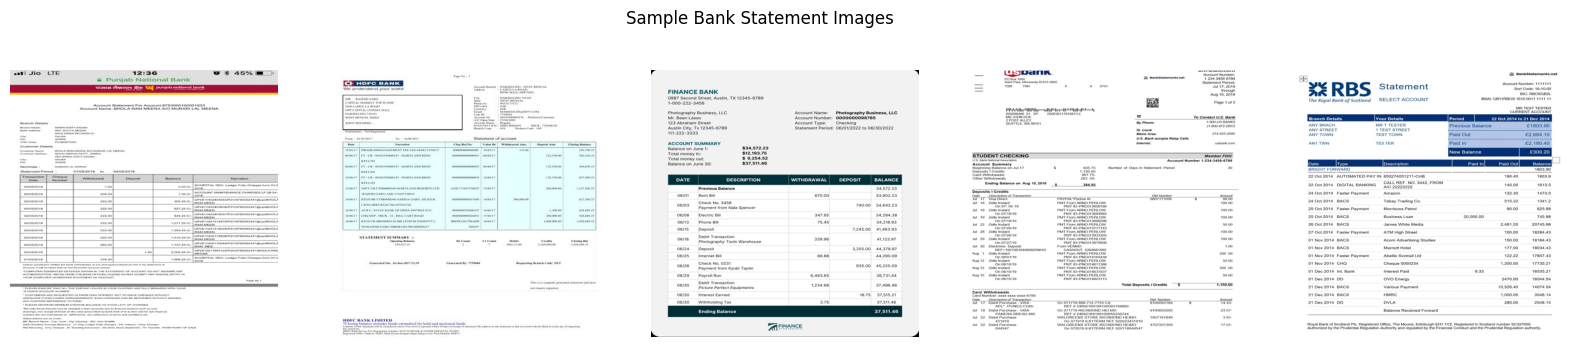

In [28]:
# Load image files
image_files = [f for f in os.listdir(image_folder_path)
               if os.path.isfile(os.path.join(image_folder_path, f))
               and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Function to properly load and resize images for Donut
def load_image(path, target_size=(480, 480)):
    img = Image.open(path).convert("RGB")
    img = img.resize(target_size)
    return img

# Load and resize all images
images = [load_image(os.path.join(image_folder_path, f)) for f in image_files]

# Test single image processing
img_path = os.path.join(image_folder_path, image_files[0])
img = load_image(img_path)
pixel_values = processor(img, return_tensors="pt", size=(480, 480)).pixel_values
print("Pixel values shape:", pixel_values.shape)

# Preview sample images
fig, axes = plt.subplots(1, 5, figsize=(20,4))
fig.suptitle('Sample Bank Statement Images')
for i, ax in enumerate(axes):
    if i < len(images):
        ax.imshow(images[i])
        ax.axis('off')
    else:
        ax.axis('off')
plt.show()


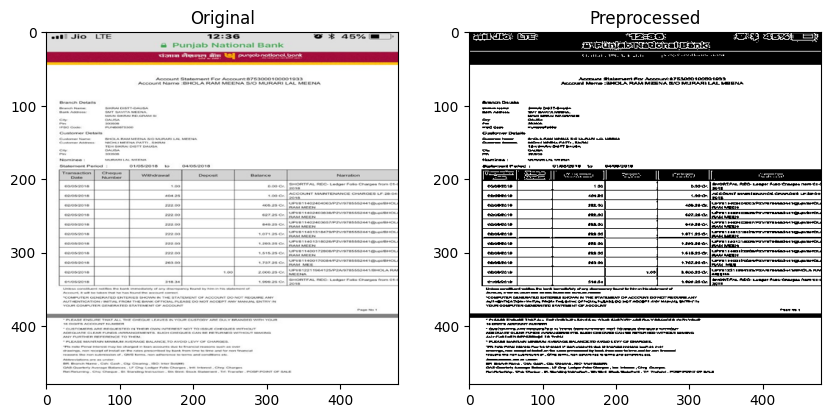

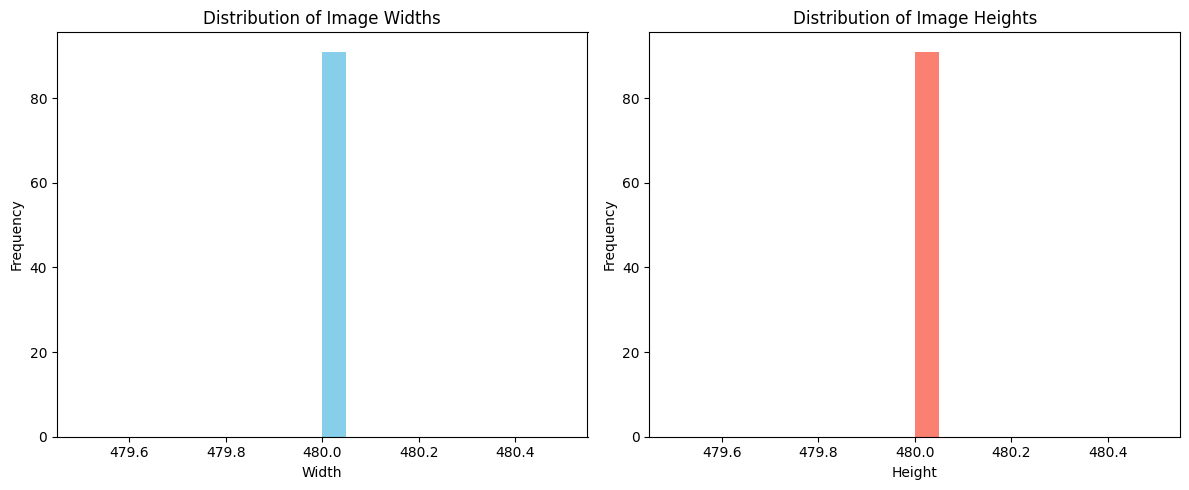

In [29]:
# Image preprocessing and Visualization
def preprocess_image(img, enhance_factor=2.5):
    img = img.convert('L')
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(enhance_factor)
    img = img.filter(ImageFilter.SHARPEN)
    arr = np.array(img)
    threshold = np.mean(arr)
    arr = np.where(arr > threshold, 255, 0).astype(np.uint8)
    return Image.fromarray(arr)

# Show before/after
sample_img = images[0]
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(sample_img)
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(preprocess_image(sample_img), cmap='gray')
plt.title('Preprocessed')
plt.show()

# Visualize distribution of widths and heights
image_widths = [img.size[0] for img in images]
image_heights = [img.size[1] for img in images]

fig, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].hist(image_widths, bins=20, color='skyblue')
axes[0].set_title('Distribution of Image Widths')
axes[0].set_xlabel('Width')
axes[0].set_ylabel('Frequency')

axes[1].hist(image_heights, bins=20, color='salmon')
axes[1].set_title('Distribution of Image Heights')
axes[1].set_xlabel('Height')
axes[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()


Define Features For Extraction

In [30]:
FEATURES = [
    "opening_balance",
    "closing_balance",
    "total_credit",
    "total_debit",
    "account_number",
    "trans_date"
]

FEATURE_SYNONYMS = {
    "money_in": "total_credit",
    "deposit": "total_credit",
    "credit_amount": "total_credit",
    "money_out": "total_debit",
    "withdrawal": "total_debit",
    "debit_amount": "total_debit",
    "acct_num": "account_number",
    "account_no": "account_number",
    "date": "trans_date"
}

def normalize_labels(raw_label):
    normalized = {}
    for k, v in raw_label.items():
        canonical_key = FEATURE_SYNONYMS.get(k, k)
        normalized[canonical_key] = v
    # Fill missing features
    for f in FEATURES:
        if f not in normalized:
            normalized[f] = None
    return normalized


In [31]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
from PIL import Image
import torch
import os
import json

class DonutDataset(Dataset):
    def __init__(self, image_paths, processor, json_folder=None, target_size=(480, 480)):
        self.image_paths = image_paths
        self.processor = processor
        self.json_folder = json_folder
        self.target_size = target_size

        # Load JSON annotation files if provided
        if json_folder:
            self.label_files = [
                os.path.join(json_folder, os.path.splitext(os.path.basename(p))[0] + ".json")
                for p in image_paths
            ]
        else:
            self.label_files = [None] * len(image_paths)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")

        # Let processor handle normalization & tensor conversion
        pixel_values = self.processor(
            img,
            return_tensors="pt",
            size=self.target_size
        ).pixel_values.squeeze(0)

        # Load and encode label
        if self.label_files[idx] and os.path.exists(self.label_files[idx]):
            with open(self.label_files[idx], "r") as f:
                json_data = json.load(f)
            text_label = json.dumps(json_data, ensure_ascii=False)
            input_ids = self.processor.tokenizer(
                text_label,
                add_special_tokens=True,
                max_length=512,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            ).input_ids.squeeze(0)
        else:
            input_ids = torch.zeros(1, dtype=torch.long)  # fallback dummy label

        return pixel_values, input_ids


def collate_fn(batch):
    pixel_values, labels = zip(*batch)
    pixel_values = torch.stack(pixel_values)

    # Pad label sequences
    labels = pad_sequence(labels, batch_first=True, padding_value=0)

    return pixel_values, labels


In [32]:
image_files_full_path = [os.path.join(image_folder_path, f) for f in image_files]
dataset = DonutDataset(image_files_full_path, processor, json_folder=donut_json_output)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

# Test one batch
for imgs, labels in train_loader:
    print("Batch images shape:", imgs.shape)
    print("Batch labels shape:", labels.shape)
    break


Train samples: 72, Validation samples: 19
Batch images shape: torch.Size([2, 3, 480, 480])
Batch labels shape: torch.Size([2, 512])


In [33]:
from inspect import getsourcelines
print(getsourcelines(load_image)[0])


['def load_image(path, target_size=(480, 480)):\n', '    img = Image.open(path).convert("RGB")\n', '    img = img.resize(target_size)\n', '    return img\n']


Epoch 1/10 → Train Loss: 3.8353, Val Loss: 0.2324
Epoch 2/10 → Train Loss: 0.1749, Val Loss: 0.0931
Epoch 3/10 → Train Loss: 0.0769, Val Loss: 0.0777
Epoch 4/10 → Train Loss: 0.0580, Val Loss: 0.0759
Epoch 5/10 → Train Loss: 0.0505, Val Loss: 0.0696
Epoch 6/10 → Train Loss: 0.0422, Val Loss: 0.0690
Epoch 7/10 → Train Loss: 0.0376, Val Loss: 0.0643
Epoch 8/10 → Train Loss: 0.0326, Val Loss: 0.0596
Epoch 9/10 → Train Loss: 0.0312, Val Loss: 0.0608
Epoch 10/10 → Train Loss: 0.0284, Val Loss: 0.0592


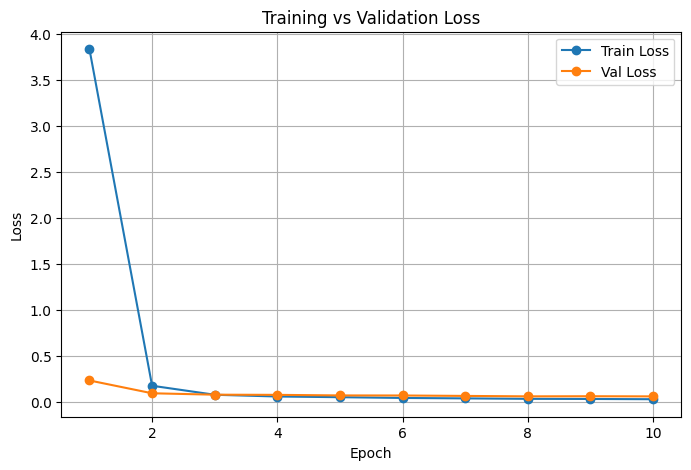

In [34]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=learning_rate)

train_losses, val_losses = [], []

for epoch in range(epochs):
    
    # Training
    model.train()
    train_loss_total = 0
    for batch in train_loader:
        pixel_values, decoder_input_ids = [x.to(device) for x in batch]
        outputs = model(pixel_values=pixel_values, labels=decoder_input_ids)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_total += loss.item()
    avg_train_loss = train_loss_total / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss_total = 0
    with torch.no_grad():
        for batch in val_loader:
            pixel_values, decoder_input_ids = [x.to(device) for x in batch]
            outputs = model(pixel_values=pixel_values, labels=decoder_input_ids)
            val_loss_total += outputs.loss.item()
    avg_val_loss = val_loss_total / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} → Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot training curves
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


/Users/macbook/Desktop/uwezo_capstone_project/uwezo_project/env311/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/macbook/Desktop/uwezo_capstone_project/uwezo_project/env311/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/macbook/Desktop/uwezo_capstone_project/uwezo_project/env311/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/macbook/Desktop/uwezo_capstone_project/uwezo_project/env311/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/macbook/Desktop/uwezo_capstone_project/uwezo_project/env311/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:552: RuntimeWar

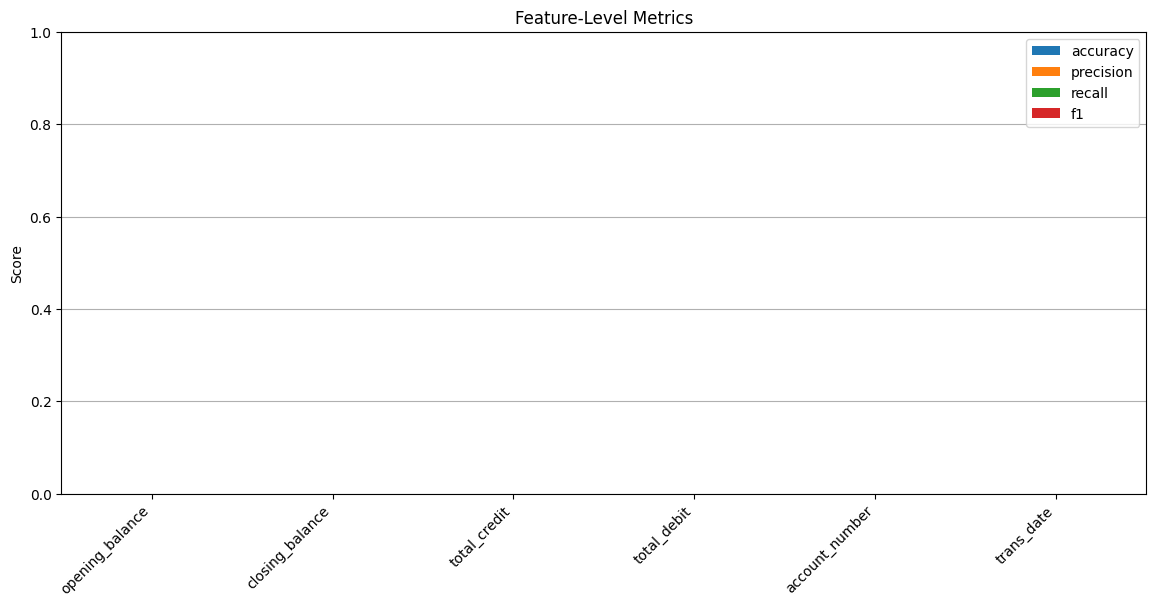

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd


def compute_feature_metrics(model, dataloader, processor, device):
    model.eval()
    y_true, y_pred = {f: [] for f in FEATURES}, {f: [] for f in FEATURES}

    with torch.no_grad():
        for batch in dataloader:
            pixel_values, decoder_input_ids = [x.to(device) for x in batch]
            outputs = model.generate(pixel_values)
            decoded_preds = [processor.decode(ids, skip_special_tokens=True) for ids in outputs]
            decoded_labels = [processor.decode(ids, skip_special_tokens=True) for ids in decoder_input_ids]

            for pred_str, label_str in zip(decoded_preds, decoded_labels):
                try:
                    pred_dict = normalize_labels(json.loads(pred_str)['label'])
                    label_dict = normalize_labels(json.loads(label_str)['label'])
                    for f in FEATURES:
                        y_true[f].append(str(label_dict.get(f)))
                        y_pred[f].append(str(pred_dict.get(f)))
                except:
                    continue

    metrics = {}
    for f in FEATURES:
        metrics[f] = {
            'accuracy': accuracy_score(y_true[f], y_pred[f]),
            'precision': precision_score(y_true[f], y_pred[f], average='micro', zero_division=0),
            'recall': recall_score(y_true[f], y_pred[f], average='micro', zero_division=0),
            'f1': f1_score(y_true[f], y_pred[f], average='micro', zero_division=0)
        }
    return metrics

feature_metrics = compute_feature_metrics(model, val_loader, processor, device)
metrics_df = pd.DataFrame(feature_metrics).T
metrics_df.plot(kind='bar', figsize=(14,6))
plt.title("Feature-Level Metrics")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()


In [38]:
# Save Fine-tuned model
fine_tuned_model_path = 'models/donut_model_finetuned'
model.save_pretrained(fine_tuned_model_path)
processor.save_pretrained(fine_tuned_model_path)
print(f"Fine-tuned model saved to {fine_tuned_model_path}")


/Users/macbook/Desktop/uwezo_capstone_project/uwezo_project/env311/lib/python3.11/site-packages/transformers/modeling_utils.py:3922: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Fine-tuned model saved to models/donut_model_finetuned
